# Feature Engineering and Model Selection

The section on model selection, particularly section 1.2 is important for the coursework


## 1 Model selection

A ML strategy might looko like:


    Choose a class of model
    Choose model hyperparameters
    Fit the model to the training data
    Use the model to predict labels for new data

The first two pieces of this—the choice of model and choice of hyperparameters—are perhaps the most important part of using these tools and techniques effectively. In order to make an informed choice, we need a way to validate that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid to do this effectively.

### 1.1 Model validation the wrong way

Let's demonstrate the naive approach to validation using the Iris data, which we saw in the previous section. We will start by loading the data:

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

In [5]:
model.fit(X, y)
y_model = model.predict(X)

from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! But is this truly measuring the expected accuracy? Have we really come upon a model that we expect to be correct 100% of the time?

As you may have gathered, the answer is no. In fact, this approach contains a fundamental flaw: it trains and evaluates the model on the same data. 

### 1.2 Model validation the right way

So what can be done? A better sense of a model's performance can be found using what's known as a holdout set: that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance. This splitting can be done using the `train_test_split` utility in Scikit-Learn

In [6]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
                                  train_size=0.5)

# fit the model on one set of data
model.fit(X1, y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

We see here a more reasonable result: the nearest-neighbor classifier is about 90% accurate on this hold-out set. The hold-out set is similar to unknown data, because the model has not "seen" it before.
    
### 1.3 Cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training. In the above case, half the dataset does not contribute to the training of the model! This is not optimal, and can cause problems – especially if the initial set of training data is small.

One way to address this is to use cross-validation; that is, to do a sequence of fits where each subset of the data is used both as a training set and as a validation set.

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's cross_val_score convenience routine to do it succinctly.

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])


## 2 Feature engineering

In this section, we will cover a few common examples of feature engineering tasks: features for representing categorical data, features for representing text, and features for representing images. Additionally, we will discuss derived features for increasing model complexity and imputation of missing data.

### Categorical data

One common type of non-numerical data is categorical data. For example, imagine you are exploring some data on housing prices, and along with numerical features like "price" and "rooms", you also have "neighborhood" information.

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

In [ ]:
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

It turns out that this is not generally a useful approach in Scikit-Learn: the package's models make the fundamental assumption that numerical features reflect algebraic quantities. Thus such a mapping would imply, for example, that Queen Anne < Fremont < Wallingford, or even that Wallingford - Queen Anne = Fremont, which (niche demographic jokes aside) does not make much sense.

In this case, one proven technique is to use one-hot encoding, which effectively creates extra columns indicating the presence or absence of a category with a value of 1 or 0, respectively. When your data comes as a list of dictionaries, Scikit-Learn's DictVectorizer will do this for you:

In [2]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

To see the meaning of each column, you can inspect the feature names

In [3]:
vec.get_feature_names()

/home/keeeto/mambaforge/envs/tf/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

### Text features

Another common need in feature engineering is to convert text to a set of representative numerical values. For example, most automatic mining of social media data relies on some form of encoding the text as numbers. One of the simplest methods of encoding data is by word counts: you take each snippet of text, count the occurrences of each word within it, and put the results in a table.

In [4]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

One way to represent this is as a vector that counts up how often a word appears in a phrase. This would be tedious to do by hand. Luckily scikit learn has your back

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
print(X)

  (0, 3)	1
  (0, 2)	1
  (0, 0)	1
  (1, 0)	1
  (1, 4)	1
  (2, 3)	1
  (2, 1)	1


This is a bit hard to digest - we can convert it to a Pandas dataframe and look at it.

In [7]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features which put too much weight on words that appear very frequently, and this can be sub-optimal in some classification algorithms. One approach to fix this is known as term frequency-inverse document frequency (TF–IDF) which weights the word counts by a measure of how often they appear in the documents.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

/home/keeeto/mambaforge/envs/tf/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


### Derived features

Sometimes it is possible to perform mathematical operations on the features or combinations of the features that mean they work much better in a given model. To get a feel for how this works consider the following data

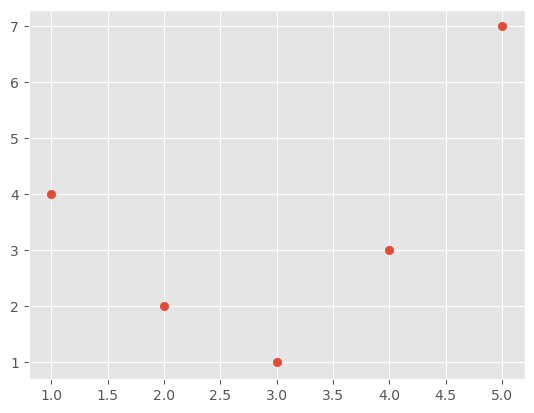

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

We could try to fit this with a simple linear model, but it is clear that if we just use the values of the x axis in a linear model we will not get a very good result.

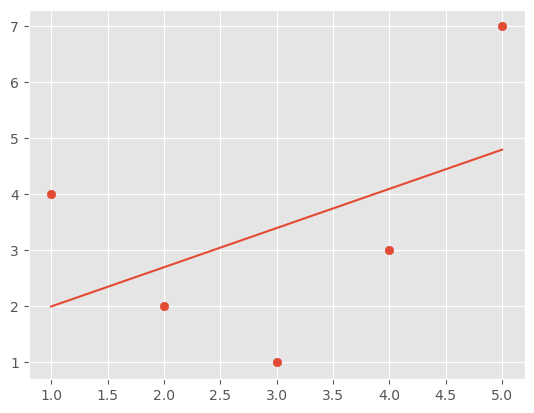

In [11]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit)

It's clear that we need a more sophisticated model to describe the relationship between x and y.

One approach to this is to transform the data, adding extra columns of features to drive more flexibility in the model. For example, we can add polynomial features to the data this way.

The derived feature matrix has one column representing $x$, and a second column representing $x^2$, and a third column representing $x^3$

In [12]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


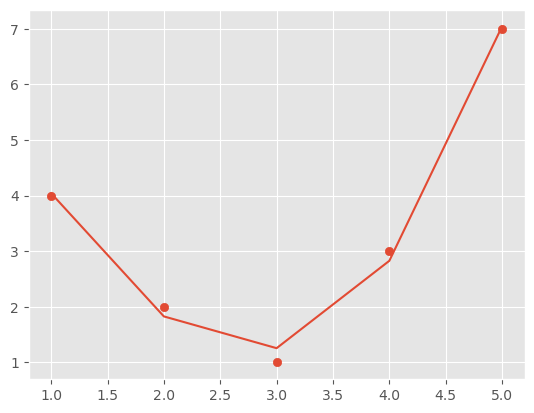

In [13]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit)

### Missing data

Another common need in feature engineering is handling of missing data. 

In [14]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

In [17]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

We see that in the resulting data, the two missing values have been replaced with the mean of the remaining values in the column. This imputed data can then be fed directly into, for example, a `LinearRegression` estimator:

In [18]:
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

### Pipelines

We can see above that there is a workflow for processing and trating data, followed by passing it into models. We can obviously do this all with a sequence of code. But it might be much cleaner if we could group the steps together in a single function that executes the workflow. This would reduce the chance of missing/changing some steps when re-running the models. We can use the `Pipeline` class from scikit for this.

For example, we might want a processing pipeline that looks something like this:

    Impute missing values using the mean
    Transform features to quadratic
    Fit a linear regression


In [20]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

In [21]:
model.fit(X, y)  # X with missing values, from above
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


# Advanced - Build a validation pipeline

Let us set up a pipeline that can transform the data into different degrees of polynomial and then perform linear regression to obtain the coeffieients.

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

We can set up some test data and apply the fitted polynmial to that data, then plot the resuls.
Which degree do we think best fits to the data?

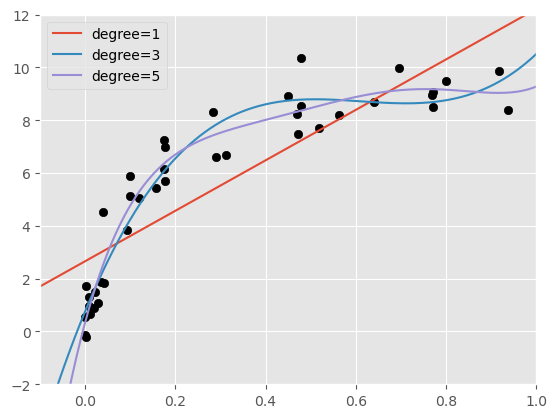

In [36]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

We can use the scikitlearn validation curve function to investigate how the training and validation loss evolves with the complexity of the model. Here we look at polynomial degress from 0 to 20.

Text(0, 0.5, 'score')

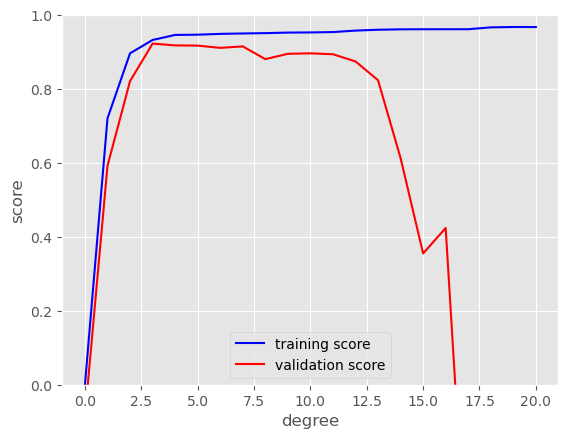

In [40]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree',
                                          param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

It looks like, beyond a third order polynomial the validation performance starts to deteriorate.

(-0.04687651021505175,
 0.9844070023112612,
 -0.7308177116555796,
 10.902869392322714)

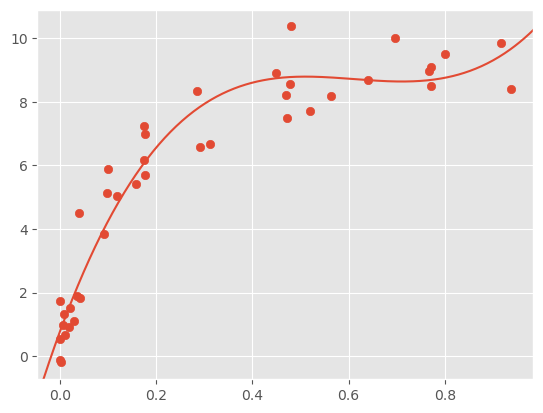

In [41]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim)